In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipystats
from scipy import signal

from utils.neurosuite import get_unit_names_sorted
from utils.psth import get_shuffled, get_spike_counts
from utils.spatial import gaussian_kernel_2D
from utils.spiketrain import smooth_gaussian
from utils.behavior import get_idxs_as_periods
#from utils.events import get_sound_event_periods

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Phase locking in diff states

In [4]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

In [16]:
session = "013608_ppcSIT_2025-01-14_10-20-14"

animal    = session.split('_')[0]
meta_file = os.path.join(source, animal, session, 'meta.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')
unit_file = os.path.join(source, animal, session, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

with h5py.File(phsl_file, 'r') as f:
    conditions = [x for x in f]
    unit_ids   = [x for x in f[conditions[0]]]
    
spike_times = {}
with h5py.File(unit_file, 'r') as f:
    #units_to_plot = get_unit_names_sorted([name for name in f])
    for unit_name in unit_ids:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])

In [17]:
speed_max = 0.04

speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]

# times of first tgt success pulses
idxs_tgt_first_ev = tgt_mx[tgt_mx[:, 4] == 1][:, 0]
tgt_first_t = sound_events[idxs_tgt_first_ev][:, 0]

# success stays
idxs_tgt_succ = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

In [18]:
# MRL
MRL_mx = np.zeros([len(unit_ids), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_ids):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [19]:
# mean firing rate
FR_mx = np.zeros([len(unit_ids), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_ids):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

### Filters

In [28]:
# MRL criteria
pv_min = 0.5
MRL_min = 0.05
MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_ids)} units > 0.5Hz firing rate")
    
# special units 
special = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198']
}
idxs_special = [unit_ids.index(x) for x in special['013608_ppcSIT_2025-01-14_10-20-14']]
print(f"{len(idxs_special)} units to be excluded as special")


# MRL
idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 0] < MRL_min)[0]

idxs_MRL_high = np.intersect1d(idxs_mfr_min, idxs_MRL_high)
idxs_MRL_high = np.setdiff1d(idxs_MRL_high, idxs_special)

idxs_MRL_low = np.intersect1d(idxs_mfr_min, idxs_MRL_low)
idxs_MRL_low = np.setdiff1d(idxs_MRL_low, idxs_special)

print(f"{len(idxs_MRL_high)} units with phase locking selected")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")

156 out of 213 units > 0.5Hz firing rate
4 units to be excluded as special
57 units with phase locking selected
80 units have kind of no phase locking


In [29]:
# show exact unit IDs selected
print([unit_ids[x] for x in idxs_MRL_high])

['1-107', '1-147', '1-375', '1-39', '1-398', '1-409', '1-429', '1-440', '1-441', '1-442', '1-449', '1-95', '2-230', '2-288', '2-289', '2-328', '2-361', '2-410', '2-433', '2-434', '2-444', '2-468', '2-478', '2-58', '2-84', '2-85', '2-99', '3-118', '3-155', '3-17', '3-18', '3-214', '3-247', '3-280', '3-294', '3-295', '3-296', '3-312', '3-331', '3-34', '3-35', '3-389', '3-404', '3-62', '3-63', '3-75', '3-87', '3-88', '4-186', '4-200', '4-249', '4-261', '4-262', '4-274', '4-324', '4-350', '4-351']


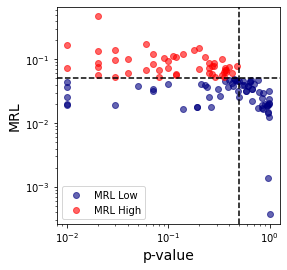

In [30]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.scatter(MRL_mx[idxs_MRL_low][:, 1], MRL_mx[idxs_MRL_low][:, 0], color='navy', alpha=0.6, label='MRL Low')
ax.scatter(MRL_mx[idxs_MRL_high][:, 1], MRL_mx[idxs_MRL_high][:, 0], color='red', alpha=0.6, label='MRL High')
ax.axvline(pv_min, ls='--', color='black')
ax.axhline(MRL_min, ls='--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('p-value', fontsize=14)
ax.set_ylabel('MRL', fontsize=14)
ax.legend()

### periods of stationarity / running

In [13]:
# Stops for a certain period (no matter where but stationary)
visit_matrices = {}  
min_durs = [12, 4]  # in sounds events, 4 events per second
conds = [['BGR_long_stays', 'SIL_long_stays'], ['BGR_long_runs', 'SIL_long_runs']]

for i, idxs_condition in enumerate([idxs_bgr_ev, idxs_sil_ev]):
    for j, idxs_loc_state in enumerate([idxs_sta_ev, idxs_run_ev]):
        periods_loc_ev = get_idxs_as_periods(np.intersect1d(idxs_loc_state, idxs_condition))
        periods_filt = periods_loc_ev[np.where(np.diff(periods_loc_ev, axis=1) > min_durs[j])[0]]

        long_pers_xy = np.zeros([len(periods_filt), 4])
        for k, ls_rec in enumerate(periods_filt):
            idx_tl_s = int(sound_events[ls_rec[0]][2])
            idx_tl_e = int(sound_events[ls_rec[1]][2])
            x_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 1]
            y_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 2]

            long_pers_xy[k] = [ls_rec[0], ls_rec[1], x_pos.mean(), y_pos.mean()]

        visit_matrices[conds[j][i]] = long_pers_xy

idxs_matrices = {}
for cond, mx in visit_matrices.items():
    idxs_long_pers_ev = []
    for ls in mx:
        idxs_long_pers_ev += list(np.arange(int(ls[0]), int(ls[1])))
    idxs_long_pers_ev = np.array(idxs_long_pers_ev)
    idxs_matrices[cond] = sound_events[idxs_long_pers_ev][:, 0]

In [14]:
for cond, mx in idxs_matrices.items():
    print(f"{cond}: {mx.shape}")

BGR_long_stays: (538,)
BGR_long_runs: (50,)
SIL_long_stays: (480,)
SIL_long_runs: (869,)


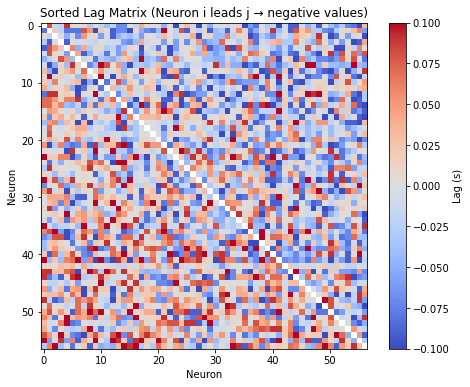

In [31]:
from sklearn.manifold import MDS

win = 0.25  # window after stim to consider (150 ms)
bin_size = 0.01  # 1 ms bin
max_lag = 0.1  # max lag for xcorr, in seconds (±50ms)

spk_times = []
for unit_id in [unit_ids[x] for x in idxs_MRL_high]:
    spk_times.append(spike_times[unit_id])

stim_times = sound_events[idxs_tgt_ev][:, 0]  # all TGT
n_neurons = len(spk_times)  # use smaller number for testing

# ------------------------------
# 1. BUILD TRIAL-ALIGNED SPIKE MATRICES
# ------------------------------

# Bin edges for PSTH
bins = np.arange(0, win, bin_size)
n_bins = len(bins) - 1
n_trials = len(stim_times)

# Trial-aligned firing: shape (n_neurons, n_trials, n_bins)
firing_matrix = np.zeros((n_neurons, n_trials, n_bins))

for i, spikes in enumerate(spk_times):
    for j, stim in enumerate(stim_times):
        trial_spikes = spikes[(spikes >= stim) & (spikes < stim + win)] - stim
        binned, _ = np.histogram(trial_spikes, bins=bins)
        firing_matrix[i, j] = binned

# ------------------------------
# 2. CROSS-CORRELOGRAMS PER PAIR
# ------------------------------

lag_bins = int(max_lag / bin_size)
lags = np.arange(-lag_bins, lag_bins + 1) * bin_size

n_pairs = int(n_neurons * (n_neurons - 1) / 2)
lag_matrix = np.zeros((n_neurons, n_neurons)) * np.nan

for i in range(n_neurons):
    for j in range(n_neurons):
        if i == j:
            continue
        # Pool across trials
        a = firing_matrix[i].flatten()
        b = firing_matrix[j].flatten()
        xcorr = signal.correlate(b, a, mode='full')
        center = len(xcorr) // 2
        win_slice = slice(center - lag_bins, center + lag_bins + 1)
        xcorr_win = xcorr[win_slice]
        peak_idx = np.argmax(xcorr_win)
        lag_matrix[i, j] = lags[peak_idx]  # lag at which i leads j

# ------------------------------
# 3. SERIATION / REORDERING
# ------------------------------

# Simple method: sort neurons by mean lag to others
mean_lags = np.nanmean(lag_matrix, axis=1)
sort_order = np.argsort(mean_lags)
sorted_lag_matrix = lag_matrix[sort_order][:, sort_order]

# ------------------------------
# 4. VISUALIZATION
# ------------------------------

plt.figure(figsize=(8, 6))
plt.imshow(sorted_lag_matrix, cmap='coolwarm', vmin=-max_lag, vmax=max_lag)
plt.title("Sorted Lag Matrix (Neuron i leads j → negative values)")
plt.colorbar(label='Lag (s)')
plt.xlabel("Neuron")
plt.ylabel("Neuron")
plt.show()

(-0.04595815546850075,
 0.06507801989518099,
 -0.043497102381861795,
 0.048445078668250964)

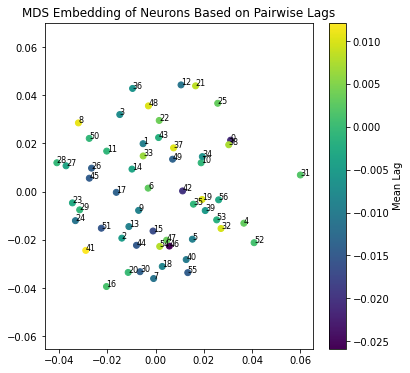

In [34]:
from sklearn.manifold import MDS

valid = ~np.isnan(lag_matrix)
distance_matrix = np.abs(lag_matrix.copy())
distance_matrix[~valid] = np.nanmean(distance_matrix)  # fill NaNs
distance_matrix = (np.abs(lag_matrix) + np.abs(lag_matrix.T)) / 2
distance_matrix[~valid] = np.nanmean(distance_matrix)  # fill NaNs

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=mean_lags, cmap='viridis')
for i, idx in enumerate(sort_order):
    plt.text(coords[idx, 0], coords[idx, 1], f"{idx}", fontsize=8)
plt.title("MDS Embedding of Neurons Based on Pairwise Lags")
plt.colorbar(label='Mean Lag')
plt.axis('equal')